Fitting 3 folds for each of 216 candidates, totalling 648 fits

Results for RandomForestRegressor:
Average R2_train: 0.6345
Average R2_test: -0.3392
Average RMSE_test: 20.9657
Average MAE_test: 17.4309
Average RPD: 1.0079


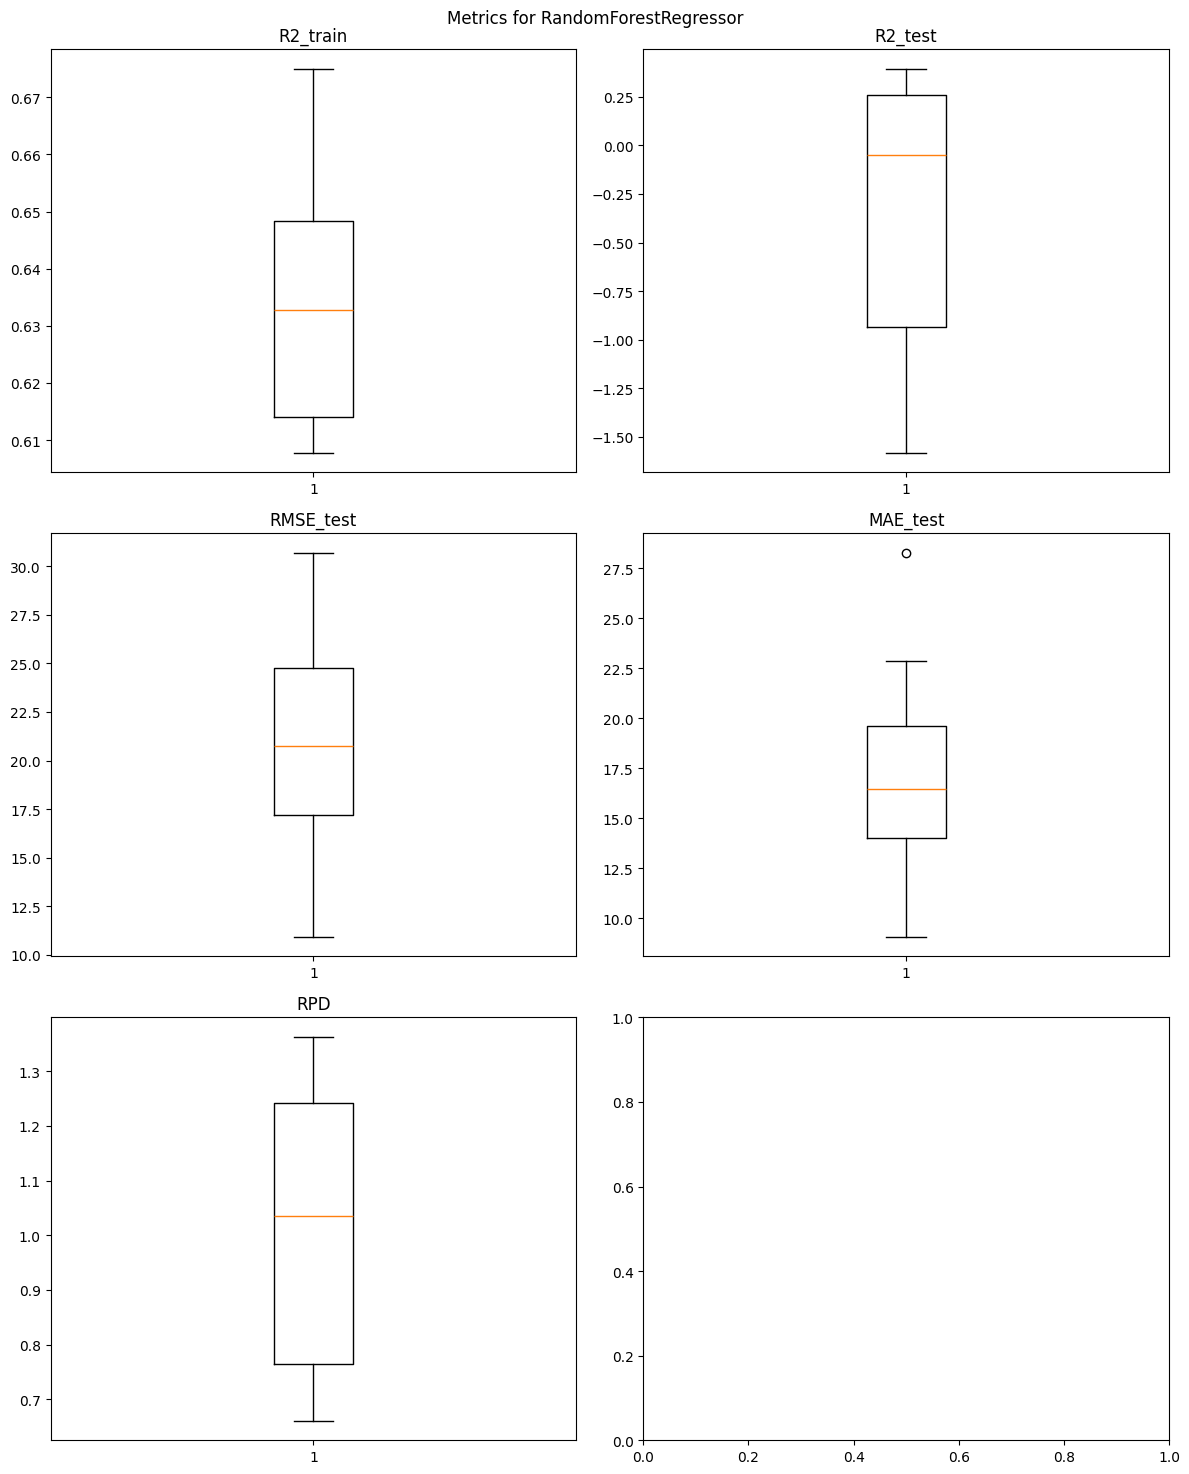

C:\Users\sahan\AppData\Local\Temp\ipykernel_33616\4158687651.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Predicted_Presin'] = best_rf.predict(X_selected)


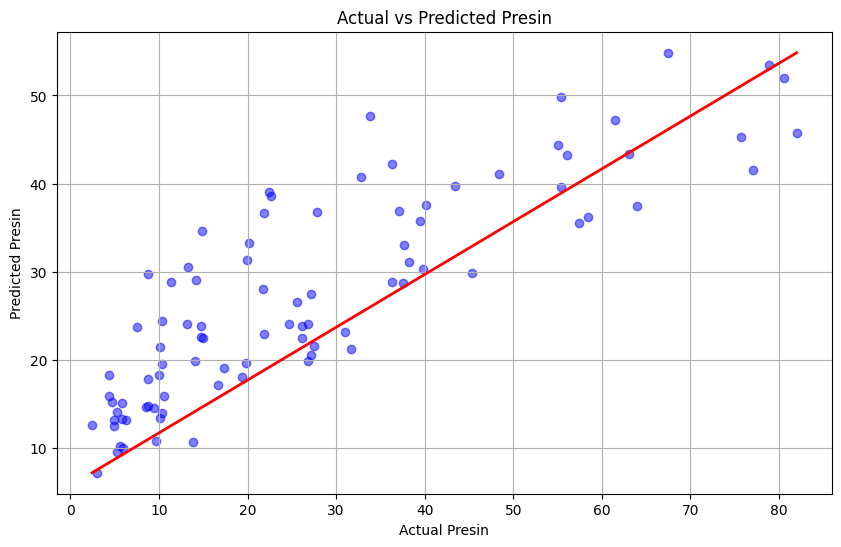


Model Accuracy:
Mean Squared Error (MSE): 159.7686
Root Mean Squared Error (RMSE): 12.6400
Mean Absolute Error (MAE): 10.0275
R-squared (R²): 0.6386


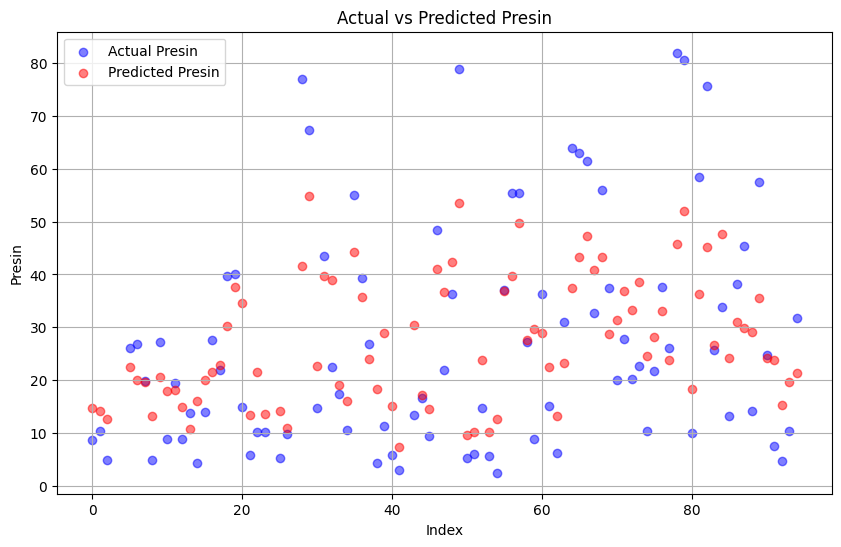

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.api import OLS, add_constant
from scipy.stats import pearsonr, zscore
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('SoilSampling-AB - SahanaYuvraj (1).csv').dropna()

# K-Fold setup
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Pearson correlation for variable selection
def get_highly_correlated_vars(data, target_column, n_vars):
    correlations = {col: pearsonr(data[col], data[target_column])[0] for col in data.columns if col != target_column}
    sorted_vars = sorted(correlations, key=correlations.get, reverse=True)
    return sorted_vars[:n_vars]

# Iterative variable selection
def iterative_variable_selection(X, y):
    best_vars = []
    remaining_vars = list(X.columns)
    best_R2 = -np.inf

    while remaining_vars:
        scores = []
        for var in remaining_vars:
            vars_to_test = best_vars + [var]
            X_subset = X[vars_to_test]
            model = OLS(y, add_constant(X_subset)).fit()
            scores.append((model.rsquared, var))
        
        scores.sort(reverse=True)
        if scores[0][0] > best_R2:
            best_R2 = scores[0][0]
            best_vars.append(scores[0][1])
            remaining_vars.remove(scores[0][1])
        else:
            break
    
    return best_vars

# Remove outliers using z-score
def remove_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data))
    return data[(z_scores < threshold).all(axis=1)]

# Remove outliers from the dataset
data_cleaned = remove_outliers_zscore(data)

# Prepare data
reflectance_columns = [col for col in data_cleaned.columns if 'reflectance' in col]
Presin_column = 'Presin'

# Feature selection using Pearson correlation
n_selected_vars = 10  # Number of variables to select
selected_vars_pearson = get_highly_correlated_vars(data_cleaned, Presin_column, n_selected_vars)

# Further selection using iterative variable selection
X_pearson_selected = data_cleaned[selected_vars_pearson]
best_vars_iterative = iterative_variable_selection(X_pearson_selected, data_cleaned[Presin_column])

X_selected = X_pearson_selected[best_vars_iterative]
y = data_cleaned[Presin_column]

# Function to evaluate the model using cross-validation
def evaluate_model(model, X, y, kf):
    metrics = {'R2_train': [], 'R2_test': [], 'RMSE_test': [], 'MAE_test': [], 'RPD': []}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        R2_train = r2_score(y_train, y_train_pred)
        R2_test = r2_score(y_test, y_test_pred)
        RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        MAE_test = mean_absolute_error(y_test, y_test_pred)
        RPD = y_test.std() / RMSE_test

        metrics['R2_train'].append(R2_train)
        metrics['R2_test'].append(R2_test)
        metrics['RMSE_test'].append(RMSE_test)
        metrics['MAE_test'].append(MAE_test)
        metrics['RPD'].append(RPD)
    
    return metrics

# Hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_selected, y)

best_rf = grid_search.best_estimator_
metrics_rf = evaluate_model(best_rf, X_selected, y, kf)

# Display the results
def print_metrics(model_name, metrics):
    print(f"\nResults for {model_name}:")
    for metric, values in metrics.items():
        print(f"Average {metric}: {np.mean(values):.4f}")

print_metrics("RandomForestRegressor", metrics_rf)

# Plotting the results
def plot_metrics(model_name, metrics):
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle(f'Metrics for {model_name}')

    metric_keys = list(metrics.keys())
    metric_values = list(metrics.values())
    
    for ax, key, values in zip(axs.ravel(), metric_keys, metric_values):
        ax.boxplot(values)
        ax.set_title(key)

    plt.tight_layout()
    plt.show()

plot_metrics('RandomForestRegressor', metrics_rf)

# Final model training
best_rf.fit(X_selected, y)
data_cleaned['Predicted_Presin'] = best_rf.predict(X_selected)

# Save the predictions to a new CSV file
data_cleaned.to_csv('reflectance_data_with_predictions_5.csv', index=False)

# Plotting actual vs. predicted Presin values
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin'], color='blue', alpha=0.5)
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin'].min(), data_cleaned['Predicted_Presin'].max()], 
         color='red', lw=2)
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin')
plt.title('Actual vs Predicted Presin')
plt.grid(True)
plt.show()

# Accuracy of the model
mse = mean_squared_error(y, data_cleaned['Predicted_Presin'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, data_cleaned['Predicted_Presin'])
r2 = r2_score(y, data_cleaned['Predicted_Presin'])

print(f"\nModel Accuracy:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned.index, data_cleaned[Presin_column], color='blue', alpha=0.5, label='Actual Presin')
plt.scatter(data_cleaned.index, data_cleaned['Predicted_Presin'], color='red', alpha=0.5, label='Predicted Presin')
plt.xlabel('Index')
plt.ylabel('Presin')
plt.title('Actual vs Predicted Presin')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import xgboost as xgb


Fitting 3 folds for each of 243 candidates, totalling 729 fits

Results for XGBoost:
Average R2_train: 0.6080
Average R2_test: -0.2072
Average RMSE_test: 20.6151
Average MAE_test: 16.9577
Average RPD: 1.0103


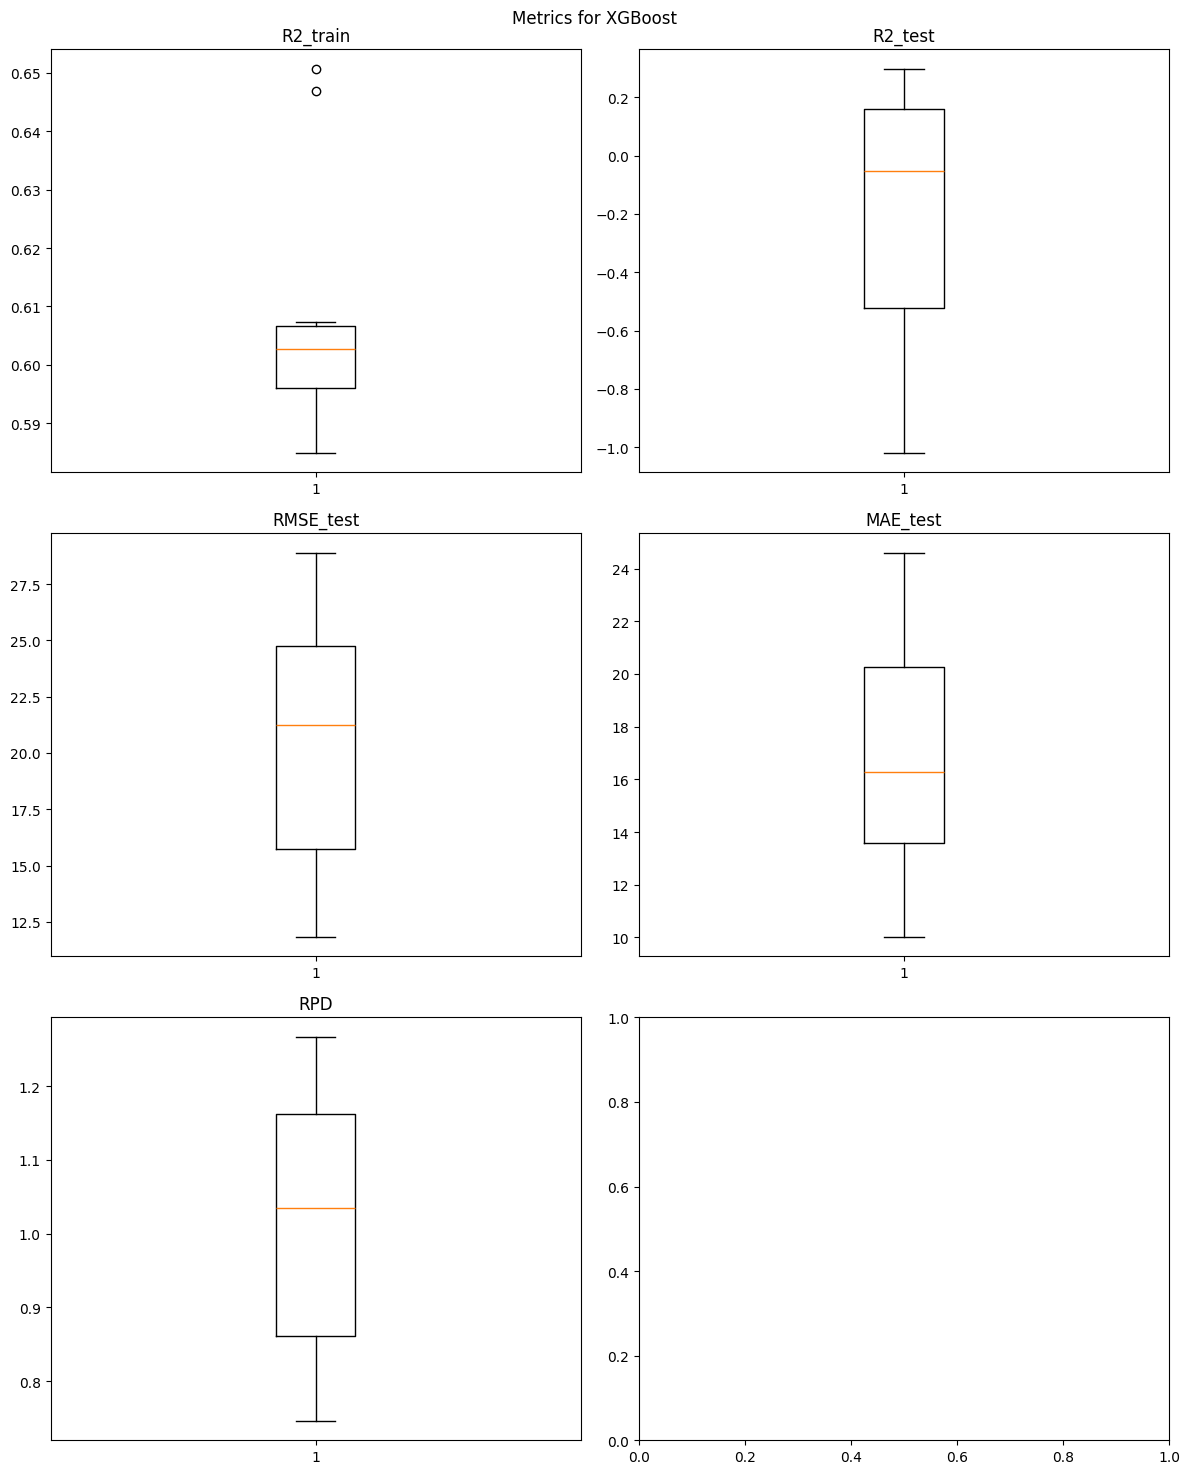


XGBoost Model Accuracy:
Mean Squared Error (MSE): 179.7752
Root Mean Squared Error (RMSE): 13.4080
Mean Absolute Error (MAE): 10.8062
R-squared (R²): 0.5933


C:\Users\sahan\AppData\Local\Temp\ipykernel_33616\1018187759.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Predicted_Presin_XGB'] = best_xgb.predict(X_selected)


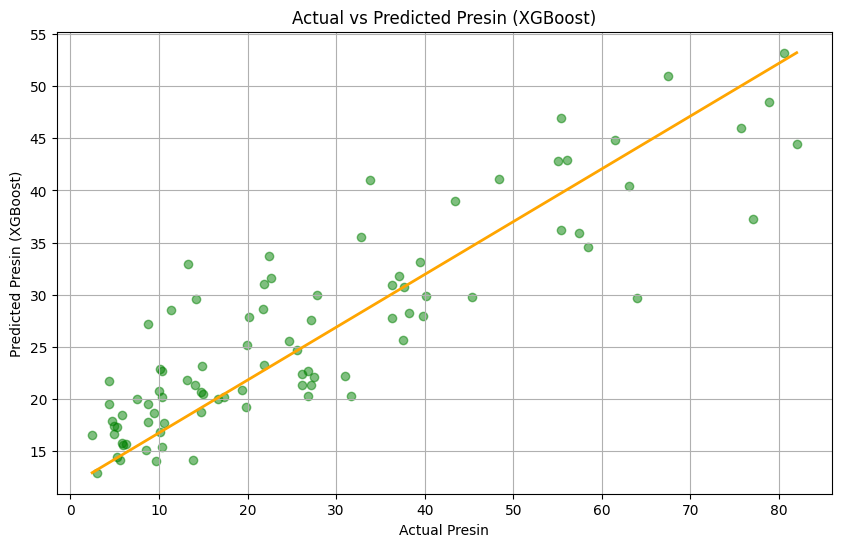

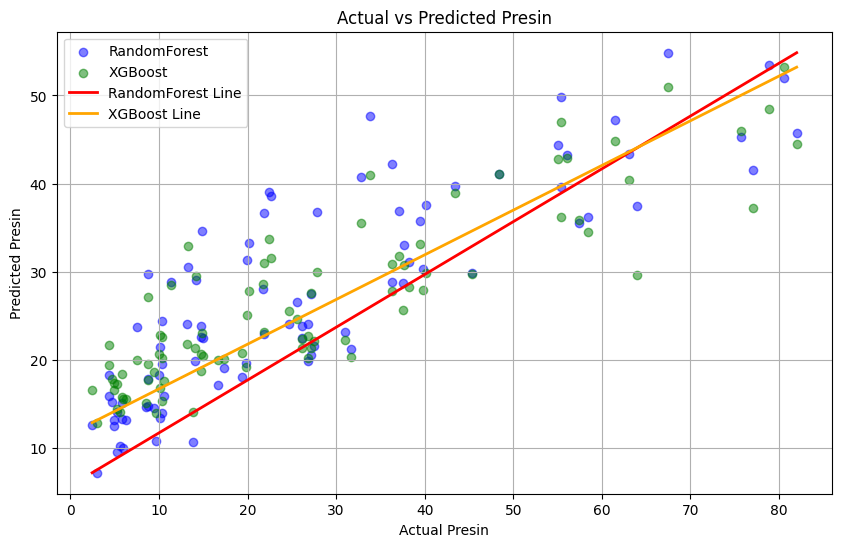

In [4]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search_xgb.fit(X_selected, y)

best_xgb = grid_search_xgb.best_estimator_
metrics_xgb = evaluate_model(best_xgb, X_selected, y, kf)

# Display XGBoost results
print_metrics("XGBoost", metrics_xgb)
plot_metrics('XGBoost', metrics_xgb)

# Final model training with XGBoost
best_xgb.fit(X_selected, y)
data_cleaned['Predicted_Presin_XGB'] = best_xgb.predict(X_selected)

# Accuracy of the XGBoost model
mse_xgb = mean_squared_error(y, data_cleaned['Predicted_Presin_XGB'])
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y, data_cleaned['Predicted_Presin_XGB'])
r2_xgb = r2_score(y, data_cleaned['Predicted_Presin_XGB'])

print(f"\nXGBoost Model Accuracy:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R-squared (R²): {r2_xgb:.4f}")

# Plotting actual vs. predicted Presin values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_XGB'], color='green', alpha=0.5)
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_XGB'].min(), data_cleaned['Predicted_Presin_XGB'].max()], 
         color='orange', lw=2)
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin (XGBoost)')
plt.title('Actual vs Predicted Presin (XGBoost)')
plt.grid(True)
plt.show()

# Plotting actual vs. predicted Presin values for both models
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin'], color='blue', alpha=0.5, label='RandomForest')
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_XGB'], color='green', alpha=0.5, label='XGBoost')
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin'].min(), data_cleaned['Predicted_Presin'].max()], 
         color='red', lw=2, label='RandomForest Line')
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_XGB'].min(), data_cleaned['Predicted_Presin_XGB'].max()], 
         color='orange', lw=2, label='XGBoost Line')
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin')
plt.title('Actual vs Predicted Presin')
plt.legend()
plt.grid(True)
plt.show()

Fitting 3 folds for each of 729 candidates, totalling 2187 fits

Results for Gradient Boosting:
Average R2_train: 0.5847
Average R2_test: -0.2743
Average RMSE_test: 20.7022
Average MAE_test: 17.5035
Average RPD: 1.0000


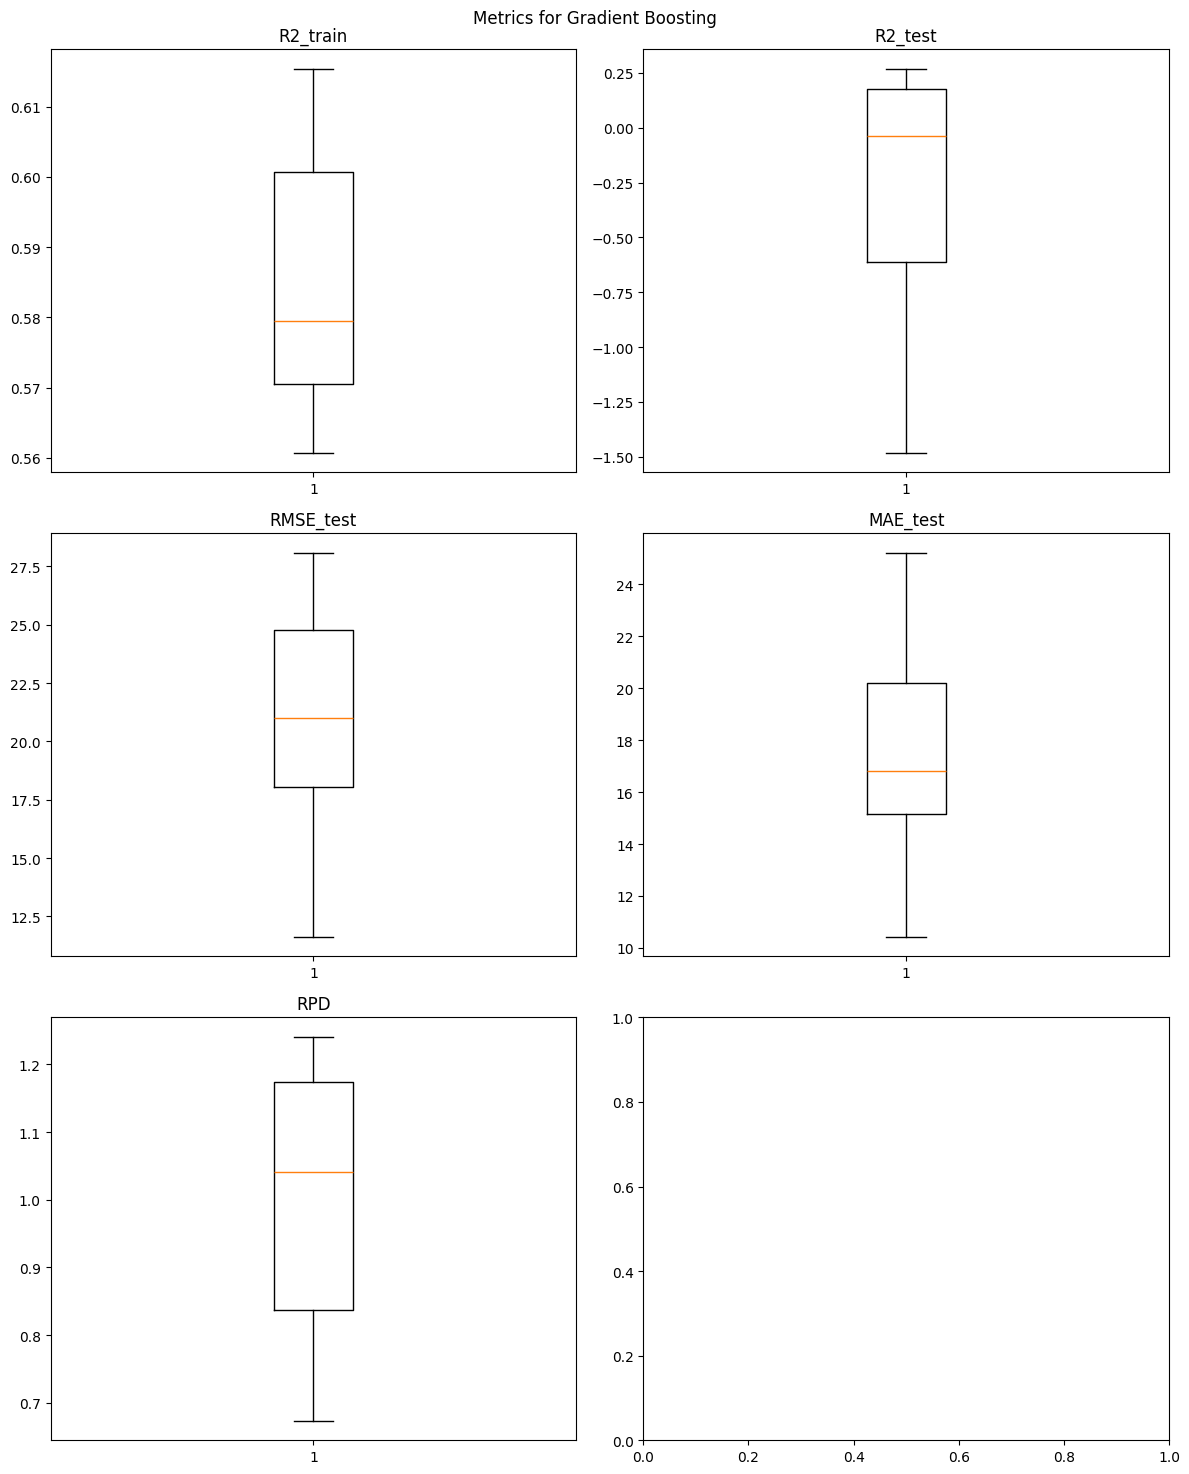


Gradient Boosting Model Accuracy:
Mean Squared Error (MSE): 184.6570
Root Mean Squared Error (RMSE): 13.5889
Mean Absolute Error (MAE): 11.0653
R-squared (R²): 0.5823


C:\Users\sahan\AppData\Local\Temp\ipykernel_33616\171480193.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Predicted_Presin_GB'] = best_gb.predict(X_selected)


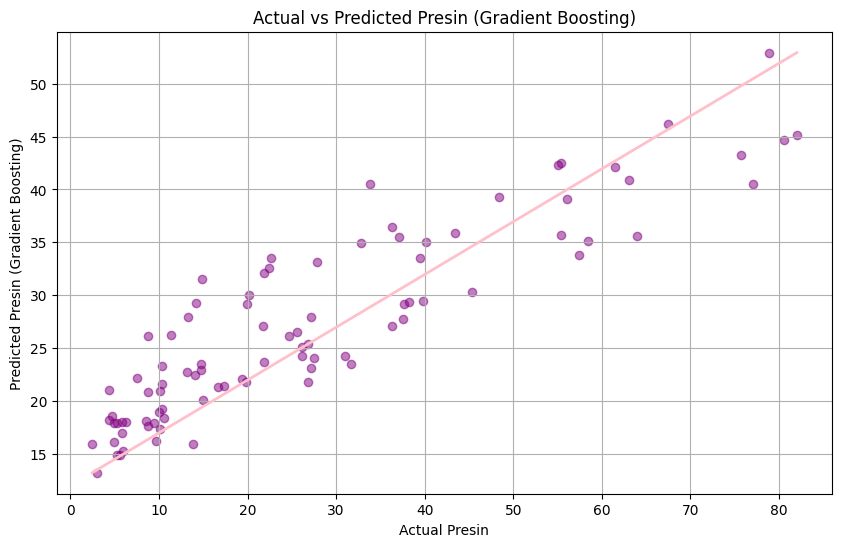

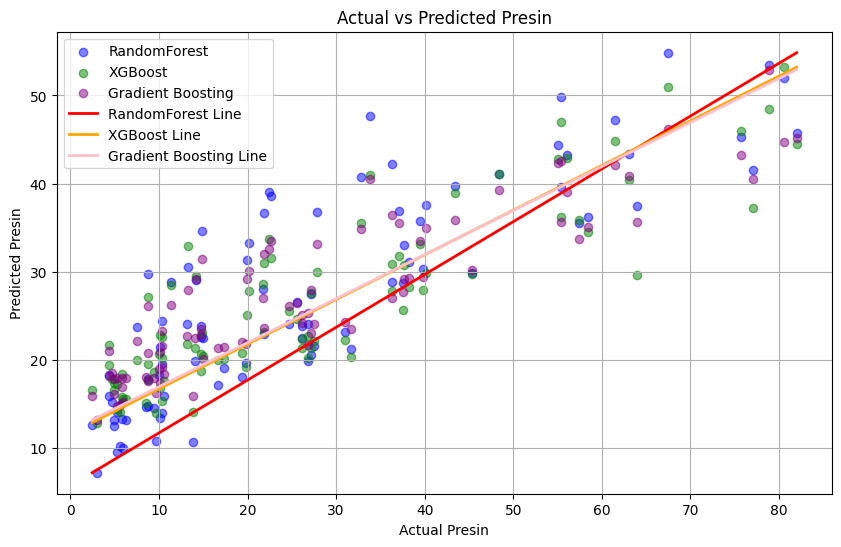

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search_gb.fit(X_selected, y)

best_gb = grid_search_gb.best_estimator_
metrics_gb = evaluate_model(best_gb, X_selected, y, kf)

# Display Gradient Boosting results
print_metrics("Gradient Boosting", metrics_gb)
plot_metrics('Gradient Boosting', metrics_gb)

# Final model training with Gradient Boosting
best_gb.fit(X_selected, y)
data_cleaned['Predicted_Presin_GB'] = best_gb.predict(X_selected)

# Accuracy of the Gradient Boosting model
mse_gb = mean_squared_error(y, data_cleaned['Predicted_Presin_GB'])
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y, data_cleaned['Predicted_Presin_GB'])
r2_gb = r2_score(y, data_cleaned['Predicted_Presin_GB'])

print(f"\nGradient Boosting Model Accuracy:")
print(f"Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"R-squared (R²): {r2_gb:.4f}")

# Plotting actual vs. predicted Presin values for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_GB'], color='purple', alpha=0.5)
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_GB'].min(), data_cleaned['Predicted_Presin_GB'].max()], 
         color='pink', lw=2)
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin (Gradient Boosting)')
plt.title('Actual vs Predicted Presin (Gradient Boosting)')
plt.grid(True)
plt.show()

# Plotting actual vs. predicted Presin values for all models
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin'], color='blue', alpha=0.5, label='RandomForest')
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_XGB'], color='green', alpha=0.5, label='XGBoost')
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_GB'], color='purple', alpha=0.5, label='Gradient Boosting')
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin'].min(), data_cleaned['Predicted_Presin'].max()], 
         color='red', lw=2, label='RandomForest Line')
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_XGB'].min(), data_cleaned['Predicted_Presin_XGB'].max()], 
         color='orange', lw=2, label='XGBoost Line')
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_GB'].min(), data_cleaned['Predicted_Presin_GB'].max()], 
         color='pink', lw=2, label='Gradient Boosting Line')
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin')
plt.title('Actual vs Predicted Presin')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Support Vector Regression (SVR)
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.01, 0.001]
}

svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search_svr.fit(X_selected, y)

best_svr = grid_search_svr.best_estimator_
metrics_svr = evaluate_model(best_svr, X_selected, y, kf)

# Display SVR results
print_metrics("Support Vector Regression (SVR)", metrics_svr)
plot_metrics('Support Vector Regression (SVR)', metrics_svr)

# Final model training with SVR
best_svr.fit(X_selected, y)
data_cleaned['Predicted_Presin_SVR'] = best_svr.predict(X_selected)

# Accuracy of the SVR model
mse_svr = mean_squared_error(y, data_cleaned['Predicted_Presin_SVR'])
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y, data_cleaned['Predicted_Presin_SVR'])
r2_svr = r2_score(y, data_cleaned['Predicted_Presin_SVR'])

print(f"\nSVR Model Accuracy:")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_svr:.4f}")
print(f"R-squared (R²): {r2_svr:.4f}")

# Plotting actual vs. predicted Presin values for SVR
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned[Presin_column], data_cleaned['Predicted_Presin_SVR'], color='cyan', alpha=0.5)
plt.plot([data_cleaned[Presin_column].min(), data_cleaned[Presin_column].max()], 
         [data_cleaned['Predicted_Presin_SVR'].min(), data_cleaned['Predicted_Presin_SVR'].max()], 
         color='magenta', lw=2)
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin (SVR)')
plt.title('Actual vs Predicted Presin (SVR)')
plt.grid(True)
plt.show()


Fitting 3 folds for each of 54 candidates, totalling 162 fits
